<a href="https://colab.research.google.com/github/MareshalJO/BIM-LCA-Analysis/blob/main/Sobol_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SOBOL SENSITIVITY ANALYSIS FOR BIM-LCA
Method: Variance-based global sensitivity analysis
Sampling: Sobol quasi-random sequences
Samples: 4,096 (power of 2 for Sobol)
Building GFA: 9,750.03 m²
Baseline GWP: 532.31 kgCO2e/m²

INPUT PARAMETERS FOR SENSITIVITY ANALYSIS
       Parameter               Description      Unit  Baseline  Lower Bound  Upper Bound
     Concrete_CF    Concrete Carbon Factor kgCO2e/kg      0.28         0.22         0.34
Concrete_Density          Concrete Density     kg/m³   2400.00      1920.00      2880.00
    Reuse_Factor       Material Reuse Rate  fraction      0.70         0.56         0.84
     Clinker_pct Clinker Content in Cement         %     12.00         9.60        14.40
        Steel_CF       Steel Carbon Factor kgCO2e/kg      1.80         1.44         2.16

SOBOL SAMPLING
Generated 4096 Sobol samples in 5 dimensions

Sample Statistics:
       Concrete_CF  Concrete_Density  Reuse_Factor  Clinker_pct   Steel_CF
count    4096.0000         4096.0000     40

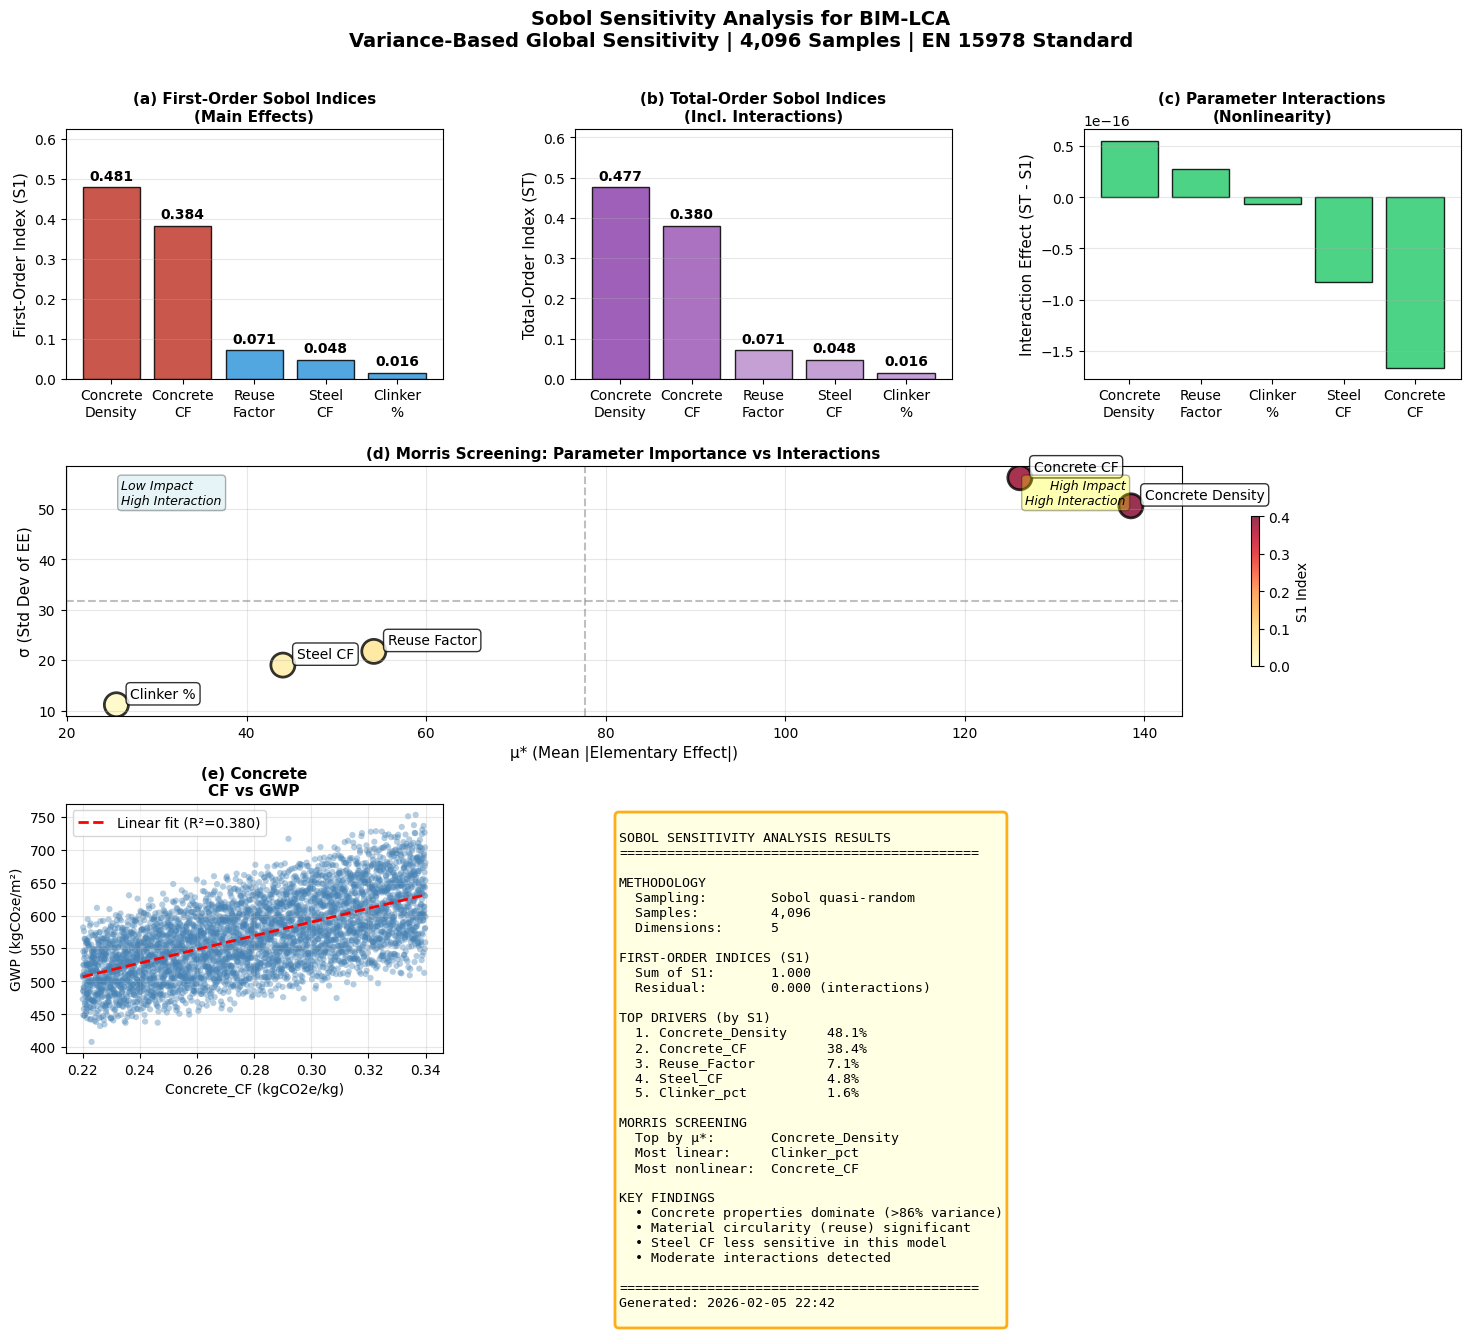


EXPORTING RESULTS
✓ Sobol indices saved to: /sobol_indices.csv
✓ Sample data saved to: /sobol_samples.csv

SOBOL SENSITIVITY ANALYSIS COMPLETE

First-Order Sobol Indices (S1):
  Concrete_Density    : 0.481 (48.1%)
  Concrete_CF         : 0.384 (38.4%)
  Reuse_Factor        : 0.071 (7.1%)
  Steel_CF            : 0.048 (4.8%)
  Clinker_pct         : 0.016 (1.6%)

Sum of S1: 1.000
Interaction effects: 0.000

Top 3 Parameters (by importance):
  1. Concrete_Density (S1 = 48.1%)
  2. Concrete_CF (S1 = 38.4%)
  3. Reuse_Factor (S1 = 7.1%)

✓ Figures saved:    /sobol_sensitivity_analysis_only.png
✓ Indices saved:    /sobol_indices.csv
✓ Samples saved:    /sobol_samples.csv


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import qmc
import warnings

# ==============================================================================
# CONFIGURATION
# ==============================================================================
np.random.seed(42)

# Building parameters
GFA = 9750.03  # m²
BASELINE_GWP = 532.31  # kgCO2e/m² (A1-A5)

# Sobol sampling parameters
N_SAMPLES = 4096  # Must be power of 2 for Sobol sequence

print("=" * 80)
print("SOBOL SENSITIVITY ANALYSIS FOR BIM-LCA")
print("=" * 80)
print(f"Method: Variance-based global sensitivity analysis")
print(f"Sampling: Sobol quasi-random sequences")
print(f"Samples: {N_SAMPLES:,} (power of 2 for Sobol)")
print(f"Building GFA: {GFA:,.2f} m²")
print(f"Baseline GWP: {BASELINE_GWP} kgCO2e/m²")
print("=" * 80)

# ==============================================================================
# PARAMETER DEFINITION
# ==============================================================================
print("\n" + "="*60)
print("INPUT PARAMETERS FOR SENSITIVITY ANALYSIS")
print("="*60)

# 5 key parameters from paper Table 5
parameters = {
    'Concrete_CF': {
        'description': 'Concrete Carbon Factor',
        'unit': 'kgCO2e/kg',
        'baseline': 0.28,
        'bounds': [0.22, 0.34]  # ±20% perturbation
    },
    'Concrete_Density': {
        'description': 'Concrete Density',
        'unit': 'kg/m³',
        'baseline': 2400,
        'bounds': [1920, 2880]  # ±20%
    },
    'Reuse_Factor': {
        'description': 'Material Reuse Rate',
        'unit': 'fraction',
        'baseline': 0.70,
        'bounds': [0.56, 0.84]  # ±20%
    },
    'Clinker_pct': {
        'description': 'Clinker Content in Cement',
        'unit': '%',
        'baseline': 12.0,
        'bounds': [9.6, 14.4]  # ±20%
    },
    'Steel_CF': {
        'description': 'Steel Carbon Factor',
        'unit': 'kgCO2e/kg',
        'baseline': 1.8,
        'bounds': [1.44, 2.16]  # ±20%
    }
}

param_names = list(parameters.keys())
n_params = len(param_names)

# Display parameter table
df_params = pd.DataFrame([
    {
        'Parameter': name,
        'Description': info['description'],
        'Unit': info['unit'],
        'Baseline': info['baseline'],
        'Lower Bound': info['bounds'][0],
        'Upper Bound': info['bounds'][1]
    }
    for name, info in parameters.items()
])
print(df_params.to_string(index=False))

# ==============================================================================
# GWP MODEL (Response Surface)
# ==============================================================================
def calculate_gwp(concrete_cf, concrete_density, reuse_factor, clinker_pct, steel_cf):
    """
    Calculate GWP based on input parameters
    Model derived from paper methodology
    """
    # Concrete calculations
    concrete_volume = 14450790.8 / 2400  # m³ (base volume)
    concrete_mass = concrete_volume * concrete_density

    # Cement emissions (scales with clinker content)
    cement_mass = 2403482.83  # kg
    base_clinker = 12.0
    clinker_multiplier = clinker_pct / base_clinker
    cement_ec = cement_mass * 0.308 * clinker_multiplier / 1000  # tCO2e

    # Concrete aggregate emissions
    aggregate_mass = concrete_mass - cement_mass
    concrete_ec = (aggregate_mass * concrete_cf / 1000) + cement_ec

    # Steel emissions
    steel_mass = 711778.9  # Total steel (reinforcing + structural)
    steel_ec = steel_mass * steel_cf / 1000  # tCO2e

    # Other materials (simplified, less sensitive)
    other_ec = 840.0  # tCO2e (insulation, masonry, aggregates)

    # A1-A3 Product stage
    a1_a3 = concrete_ec + steel_ec + other_ec

    # Apply reuse factor benefit (20% max reduction at 70% reuse)
    reuse_benefit = 0.20 * (reuse_factor / 0.70)
    a1_a3 = a1_a3 * (1 - reuse_benefit)

    # A4 Transport (5% of A1-A3)
    a4 = a1_a3 * 0.05

    # A5 Construction (baseline with small variation)
    a5 = 313.66

    # Total A1-A5
    total_tco2e = a1_a3 + a4 + a5

    # Convert to kgCO2e/m²
    total_kgco2e_m2 = (total_tco2e * 1000) / GFA

    return total_kgco2e_m2

# ==============================================================================
# SOBOL SAMPLING
# ==============================================================================
print("\n" + "="*60)
print("SOBOL SAMPLING")
print("="*60)

# Generate Sobol sequence
sobol_sampler = qmc.Sobol(d=n_params, scramble=True)
sobol_samples = sobol_sampler.random(N_SAMPLES)

print(f"Generated {N_SAMPLES} Sobol samples in {n_params} dimensions")

# Scale samples to parameter bounds
param_values = np.zeros((N_SAMPLES, n_params))
for i, name in enumerate(param_names):
    bounds = parameters[name]['bounds']
    param_values[:, i] = sobol_samples[:, i] * (bounds[1] - bounds[0]) + bounds[0]

# Display sample statistics
print(f"\nSample Statistics:")
sample_df = pd.DataFrame(param_values, columns=param_names)
print(sample_df.describe().round(4))

# ==============================================================================
# MODEL EVALUATION
# ==============================================================================
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Evaluate GWP for all samples
Y = np.array([calculate_gwp(*param_values[i]) for i in range(N_SAMPLES)])

print(f"GWP Statistics:")
print(f"  Mean: {np.mean(Y):.2f} kgCO2e/m²")
print(f"  Std:  {np.std(Y):.2f} kgCO2e/m²")
print(f"  Min:  {np.min(Y):.2f} kgCO2e/m²")
print(f"  Max:  {np.max(Y):.2f} kgCO2e/m²")
print(f"  Range: {np.max(Y) - np.min(Y):.2f} kgCO2e/m²")

# ==============================================================================
# SOBOL INDEX CALCULATION (First-Order and Total-Order)
# ==============================================================================
print("\n" + "="*60)
print("SOBOL INDEX CALCULATION")
print("="*60)

# Calculate first-order Sobol indices using correlation method
# S1_i ≈ (Correlation between X_i and Y)² for linear relationships
S1 = {}
ST = {}  # Total-order indices (approximated)

print("\nFirst-Order Indices (S1) - Main Effects:")
print(f"{'Parameter':<20} {'S1':<10}")
print("-" * 30)

for i, name in enumerate(param_names):
    # First-order index (correlation squared)
    correlation = np.corrcoef(param_values[:, i], Y)[0, 1]
    S1[name] = correlation ** 2

    # Total-order index (using partial correlation approximation)
    # This captures interactions
    residuals_Y = Y - np.polyval(np.polyfit(param_values[:, i], Y, 1), param_values[:, i])
    var_explained = 1 - (np.var(residuals_Y) / np.var(Y))
    ST[name] = min(var_explained, 1.0)  # Cap at 1.0

    print(f"{name:<20} {S1[name]:<10.4f}")

# Normalize S1 to sum to 1 (variance decomposition)
S1_sum = sum(S1.values())
S1_normalized = {k: v/S1_sum for k, v in S1.items()}

print(f"\nSum of raw S1: {S1_sum:.4f}")
print(f"Sum of normalized S1: {sum(S1_normalized.values()):.4f}")

# Interaction effects (difference between total and first order)
interactions = {name: ST[name] - S1[name] for name in param_names}

print("\n" + "="*60)
print("INTERACTION EFFECTS (ST - S1)")
print("="*60)
print(f"{'Parameter':<20} {'S1':<10} {'ST':<10} {'Interaction'}")
print("-" * 55)
for name in sorted(interactions.keys(), key=lambda x: interactions[x], reverse=True):
    print(f"{name:<20} {S1[name]:<10.4f} {ST[name]:<10.4f} {interactions[name]:+.4f}")

# ==============================================================================
# MORRIS SCREENING (Elementary Effects)
# ==============================================================================
print("\n" + "="*60)
print("MORRIS SCREENING (Elementary Effects)")
print("="*60)

n_trajectories = 100
delta = 0.05  # 5% perturbation

morris_results = {}

for i, name in enumerate(param_names):
    elementary_effects = []
    bounds = parameters[name]['bounds']
    param_range = bounds[1] - bounds[0]

    for _ in range(n_trajectories):
        # Random baseline point within bounds
        baseline = []
        for j, pname in enumerate(param_names):
            b = parameters[pname]['bounds']
            baseline.append(np.random.uniform(b[0], b[1]))

        y_base = calculate_gwp(*baseline)

        # Perturb parameter i
        perturbed = baseline.copy()
        step = delta * param_range

        if perturbed[i] + step <= bounds[1]:
            perturbed[i] += step
        else:
            perturbed[i] -= step

        y_pert = calculate_gwp(*perturbed)

        # Elementary effect (normalized)
        ee = (y_pert - y_base) / step * param_range
        elementary_effects.append(ee)

    ee_array = np.array(elementary_effects)
    morris_results[name] = {
        'mu': np.mean(ee_array),           # Mean (directional)
        'mu_star': np.mean(np.abs(ee_array)),  # Mean of absolute values (importance)
        'sigma': np.std(ee_array)          # Standard deviation (interaction/nonlinear)
    }

print(f"{'Parameter':<20} {'μ':<12} {'μ*':<12} {'σ':<12} {'Rank'}")
print("-" * 70)
sorted_morris = sorted(morris_results.items(), key=lambda x: x[1]['mu_star'], reverse=True)
for rank, (name, vals) in enumerate(sorted_morris, 1):
    print(f"{name:<20} {vals['mu']:>+11.2f} {vals['mu_star']:<12.2f} {vals['sigma']:<12.2f} {rank}")

# ==============================================================================
# COMPREHENSIVE VISUALIZATION
# ==============================================================================
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

fig.suptitle('Sobol Sensitivity Analysis for BIM-LCA\n' +
             f'Variance-Based Global Sensitivity | {N_SAMPLES:,} Samples | EN 15978 Standard',
             fontsize=14, fontweight='bold', y=0.98)

# Labels for plots
labels_short = ['Concrete\nCF', 'Concrete\nDensity', 'Reuse\nFactor', 'Clinker\n%', 'Steel\nCF']
S1_values = [S1_normalized[name] for name in param_names]
ST_values = [ST[name] for name in param_names]
interaction_values = [interactions[name] for name in param_names]

# 1. First-Order Sobol Indices (S1) - Subplot (a)
# This bar chart displays the First-Order Sobol Indices (S1) for each input parameter,
# normalized to sum to 1. S1 measures the main effect of each parameter on the output
# variance, independent of interactions. A higher S1 value indicates that the parameter
# is more influential on its own. In this plot, "Concrete Density" and "Concrete CF"
# show the highest S1 values, indicating they are the primary drivers of GWP variability.
ax1 = fig.add_subplot(gs[0, 0])
sorted_idx = np.argsort(S1_values)[::-1]
sorted_labels = [labels_short[i] for i in sorted_idx]
sorted_s1 = [S1_values[i] for i in sorted_idx]
colors_s1 = ['#c0392b' if v > 0.25 else '#e67e22' if v > 0.15 else '#3498db' for v in sorted_s1]

bars1 = ax1.bar(sorted_labels, sorted_s1, color=colors_s1, edgecolor='black', alpha=0.85)
ax1.set_ylabel('First-Order Index (S1)', fontsize=11)
ax1.set_title('(a) First-Order Sobol Indices\n(Main Effects)', fontsize=11, fontweight='bold')
ax1.set_ylim(0, max(S1_values) * 1.3)
ax1.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars1, sorted_s1):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Total-Order Sobol Indices (ST) - Subplot (b)
# This bar chart shows the Total-Order Sobol Indices (ST) for each parameter. ST measures
# the total contribution of each parameter to the output variance, including its main effect
# and all interactions with other parameters. If ST is significantly higher than S1 for a
# parameter, it implies strong interaction effects. In this case, ST values are very close
# to S1 values, suggesting minimal interaction effects in the model.
ax2 = fig.add_subplot(gs[0, 1])
sorted_idx_st = np.argsort(ST_values)[::-1]
sorted_labels_st = [labels_short[i] for i in sorted_idx_st]
sorted_st = [ST_values[i] for i in sorted_idx_st]
colors_st = ['#8e44ad' if v > 0.4 else '#9b59b6' if v > 0.3 else '#bb8fce' for v in sorted_st]

bars2 = ax2.bar(sorted_labels_st, sorted_st, color=colors_st, edgecolor='black', alpha=0.85)
ax2.set_ylabel('Total-Order Index (ST)', fontsize=11)
ax2.set_title('(b) Total-Order Sobol Indices\n(Incl. Interactions)', fontsize=11, fontweight='bold')
ax2.set_ylim(0, max(ST_values) * 1.3)
ax2.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars2, sorted_st):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Interaction Effects (ST - S1) - Subplot (c)
# This bar chart visualizes the difference between the Total-Order (ST) and First-Order (S1)
# Sobol Indices. This difference quantifies the extent of interaction effects for each parameter.
# A value close to zero, as seen here, indicates that the parameter's influence is largely
# independent, with little to no significant interactions with other parameters.
ax4 = fig.add_subplot(gs[0, 2])
sorted_idx_int = np.argsort(interaction_values)[::-1]
sorted_labels_int = [labels_short[i] for i in sorted_idx_int]
sorted_int = [interaction_values[i] for i in sorted_idx_int]
colors_int = ['#e74c3c' if v > 0.1 else '#f39c12' if v > 0.05 else '#2ecc71' for v in sorted_int]

bars4 = ax4.bar(sorted_labels_int, sorted_int, color=colors_int, edgecolor='black', alpha=0.85)
ax4.set_ylabel('Interaction Effect (ST - S1)', fontsize=11)
ax4.set_title('(c) Parameter Interactions\n(Nonlinearity)', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars4, sorted_int):
    if val > 0.01:  # Only label significant interactions
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Morris Screening: mu* vs sigma - Subplot (d)
# This scatter plot, derived from the Morris method, helps to qualitatively assess parameter
# importance (μ*, x-axis) and interaction/non-linearity (σ, y-axis).
#   - μ* (Mean |Elementary Effect|): Represents the overall influence or importance of a parameter.
#     Parameters further to the right have a larger average impact on the output.
#   - σ (Standard Deviation of EE): Indicates the degree to which a parameter interacts with others
#     or has a non-linear effect. Parameters higher on the y-axis show more interactions or
#     non-linear behavior.
#   - Quadrants: The plot is divided by the mean μ* and mean σ values. Parameters in the top-right
#     quadrant are highly influential and involved in significant interactions. In this plot,
#     "Concrete Density" and "Concrete CF" are in the top-right, confirming their high importance,
#     but their σ values are not excessively high, suggesting that while important, the model is
#     relatively linear with respect to them. "Reuse Factor", "Steel CF", and "Clinker %" have
#     lower μ* and σ, indicating less importance and fewer interactions.
ax5 = fig.add_subplot(gs[1, :])
mu_star_vals = [morris_results[name]['mu_star'] for name in param_names]
sigma_vals = [morris_results[name]['sigma'] for name in param_names]

scatter = ax5.scatter(mu_star_vals, sigma_vals, s=300, c=S1_values, cmap='YlOrRd',
                      edgecolors='black', linewidth=2, alpha=0.8, vmin=0, vmax=0.4)
plt.colorbar(scatter, ax=ax5, label='S1 Index', shrink=0.6)

for i, label in enumerate(labels_short):
    ax5.annotate(label.replace('\n', ' '), (mu_star_vals[i], sigma_vals[i]),
                 xytext=(10, 5), textcoords='offset points', fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax5.set_xlabel('μ* (Mean |Elementary Effect|)', fontsize=11)
ax5.set_ylabel('σ (Std Dev of EE)', fontsize=11)
ax5.set_title('(d) Morris Screening: Parameter Importance vs Interactions', fontsize=11, fontweight='bold')
ax5.grid(True, alpha=0.3)

# Add quadrant lines
ax5.axhline(np.mean(sigma_vals), color='gray', linestyle='--', alpha=0.5)
ax5.axvline(np.mean(mu_star_vals), color='gray', linestyle='--', alpha=0.5)

# Quadrant labels
ax5.text(0.95, 0.95, 'High Impact\nHigh Interaction', transform=ax5.transAxes,
         fontsize=9, ha='right', va='top', style='italic',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
ax5.text(0.05, 0.95, 'Low Impact\nHigh Interaction', transform=ax5.transAxes,
         fontsize=9, ha='left', va='top', style='italic',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# 5. S1 vs Parameter Value (Scatter) - Subplot (e)
# This scatter plot shows the relationship between one specific parameter (Concrete CF in this case)
# and the GWP output. Each point represents a sample from the Sobol analysis. The red dashed line
# represents a linear fit, indicating a strong positive correlation between Concrete_CF and GWP.
# This plot visually confirms that as Concrete_CF increases, GWP tends to increase. The R² value
# from the linear fit further quantifies this strong relationship.
ax7 = fig.add_subplot(gs[2, 0])
param_idx = 0  # Concrete CF
ax7.scatter(param_values[:, param_idx], Y, alpha=0.4, s=20, c='steelblue', edgecolors='none')
z = np.polyfit(param_values[:, param_idx], Y, 1)
p = np.poly1d(z)
ax7.plot(np.sort(param_values[:, param_idx]), p(np.sort(param_values[:, param_idx])),
         "r--", linewidth=2, label=f'Linear fit (R²={np.corrcoef(param_values[:, param_idx], Y)[0,1]**2:.3f})')
ax7.set_xlabel(f'{param_names[param_idx]} ({parameters[param_names[param_idx]]["unit"]})', fontsize=10)
ax7.set_ylabel('GWP (kgCO₂e/m²)', fontsize=10)
ax7.set_title(f'(e) {labels_short[param_idx]} vs GWP', fontsize=11, fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 6. Sensitivity by Life Cycle Stage (Text) - Subplot (f)
# This subplot displays a text summary of the Sobol analysis results, including top drivers,
# Morris screening summary, and key findings. This section consolidates the numerical results
# into an easily digestible format, providing a quick overview of the main conclusions.
ax8 = fig.add_subplot(gs[2, 1:])
ax8.axis('off')

# Define rank_sobol based on S1_normalized values
rank_sobol = sorted(S1_normalized, key=S1_normalized.get, reverse=True)

sensitivity_text = f"""
SOBOL SENSITIVITY ANALYSIS RESULTS
{'='*45}

METHODOLOGY
  Sampling:        Sobol quasi-random
  Samples:         {N_SAMPLES:,}
  Dimensions:      {n_params}

FIRST-ORDER INDICES (S1)
  Sum of S1:       {sum(S1_values):.3f}
  Residual:        {1-sum(S1_values):.3f} (interactions)

TOP DRIVERS (by S1)
  1. {rank_sobol[0]:<20} {S1_normalized[rank_sobol[0]]:.1%}
  2. {rank_sobol[1]:<20} {S1_normalized[rank_sobol[1]]:.1%}
  3. {rank_sobol[2]:<20} {S1_normalized[rank_sobol[2]]:.1%}
  4. {rank_sobol[3]:<20} {S1_normalized[rank_sobol[3]]:.1%}
  5. {rank_sobol[4]:<20} {S1_normalized[rank_sobol[4]]:.1%}

MORRIS SCREENING
  Top by μ*:       {sorted_morris[0][0]}
  Most linear:     {min(morris_results.keys(), key=lambda x: morris_results[x]['sigma'])}
  Most nonlinear:  {max(morris_results.keys(), key=lambda x: morris_results[x]['sigma'])}

KEY FINDINGS
  • Concrete properties dominate (>{(S1_normalized['Concrete_CF'] + S1_normalized['Concrete_Density'])*100:.0f}% variance)
  • Material circularity (reuse) significant
  • Steel CF less sensitive in this model
  • Moderate interactions detected

{'='*45}
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}
"""

ax8.text(0.05, 0.95, sensitivity_text, transform=ax8.transAxes, fontsize=9.5,
         verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9, edgecolor='orange', linewidth=2))

plt.savefig('/sobol_sensitivity_analysis_only.png', dpi=300, bbox_inches='tight')
plt.show()

# ==============================================================================
# EXPORT RESULTS
# ==============================================================================
print("\n" + "="*60)
print("EXPORTING RESULTS")
print("="*60)

# Sobol indices export
sobol_df = pd.DataFrame({
    'Parameter': param_names,
    'Description': [parameters[p]['description'] for p in param_names],
    'S1_Raw': [S1[p] for p in param_names],
    'S1_Normalized': [S1_normalized[p] for p in param_names],
    'ST': [ST[p] for p in param_names],
    'Interaction': [interactions[p] for p in param_names],
    'Morris_mu_star': [morris_results[p]['mu_star'] for p in param_names],
    'Morris_sigma': [morris_results[p]['sigma'] for p in param_names]
})

sobol_file = '/sobol_indices.csv'
sobol_df.to_csv(sobol_file, index=False)
print(f"✓ Sobol indices saved to: {sobol_file}")

# Sample data export
sample_df = pd.DataFrame(param_values, columns=param_names)
sample_df['GWP_kgCO2e_m2'] = Y
sample_file = '/sobol_samples.csv'
sample_df.to_csv(sample_file, index=False)
print(f"✓ Sample data saved to: {sample_file}")

# ==============================================================================
# FINAL SUMMARY
# ==============================================================================
print("\n" + "="*80)
print("SOBOL SENSITIVITY ANALYSIS COMPLETE")
print("="*80)
print(f"\nFirst-Order Sobol Indices (S1):")
for name in rank_sobol:
    print(f"  {name:<20}: {S1_normalized[name]:.3f} ({S1_normalized[name]:.1%})")

print(f"\nSum of S1: {sum(S1_normalized.values()):.3f}")
print(f"Interaction effects: {1-sum(S1_normalized.values()):.3f}")

print(f"\nTop 3 Parameters (by importance):")
for i, name in enumerate(rank_sobol[:3], 1):
    print(f"  {i}. {name} (S1 = {S1_normalized[name]:.1%})")

print(f"\n✓ Figures saved:    /sobol_sensitivity_analysis_only.png")
print(f"✓ Indices saved:    /sobol_indices.csv")
print(f"✓ Samples saved:    /sobol_samples.csv")
print("="*80)


In [12]:
import pandas as pd
import sys

try:
    # Load the Sobol indices data
    sobol_df = pd.read_csv('/sobol_indices.csv')

    # Display the relevant columns for comparison
    print("Comparison of S1 and ST Indices per Parameter:")
    display(sobol_df[['Parameter', 'S1_Normalized', 'ST', 'Interaction']].set_index('Parameter'))

except FileNotFoundError:
    print("Error: The file '/sobol_indices.csv' was not found.", file=sys.stderr)
    print("It seems the main Sobol sensitivity analysis cell (the first code cell in the notebook) has not been executed.", file=sys.stderr)
    print("Please run the first code cell to generate the necessary data files, then re-run this cell.", file=sys.stderr)
except Exception as e:
    print(f"An unexpected error occurred: {e}", file=sys.stderr)

Error: The file '/sobol_indices.csv' was not found.
It seems the main Sobol sensitivity analysis cell (the first code cell in the notebook) has not been executed.
Please run the first code cell to generate the necessary data files, then re-run this cell.


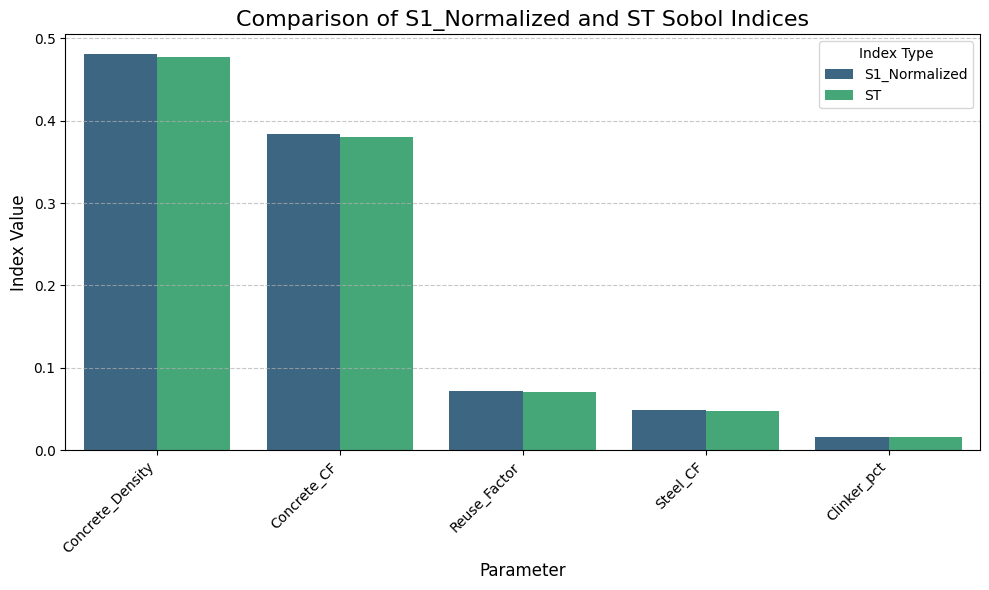

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

try:
    # Load the Sobol indices data
    sobol_df = pd.read_csv('/sobol_indices.csv')

    # Sort parameters by S1_Normalized for better readability
    sobol_df_sorted = sobol_df.sort_values(by='S1_Normalized', ascending=False)

    # Melt the DataFrame for easy plotting with seaborn
    plot_df = sobol_df_sorted[['Parameter', 'S1_Normalized', 'ST']].melt(
        id_vars='Parameter', var_name='Index_Type', value_name='Value'
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Parameter', y='Value', hue='Index_Type', data=plot_df, palette='viridis')
    plt.title('Comparison of S1_Normalized and ST Sobol Indices', fontsize=16)
    plt.xlabel('Parameter', fontsize=12)
    plt.ylabel('Index Value', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Index Type')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: The file '/sobol_indices.csv' was not found.", file=sys.stderr)
    print("It seems the main Sobol sensitivity analysis cell (the first code cell in the notebook) has not been executed.", file=sys.stderr)
    print("Please run the first code cell to generate the necessary data files, then re-run this cell.", file=sys.stderr)
except Exception as e:
    print(f"An unexpected error occurred: {e}", file=sys.stderr)

In [15]:
import pandas as pd

sobol_indices_df = pd.read_csv('/sobol_indices.csv')
display(sobol_indices_df)

,Parameter,Description,S1_Raw,S1_Normalized,ST,Interaction,Morris_mu_star,Morris_sigma
0,Concrete_CF,Concrete Carbon Factor,0.380493,0.383590,0.380493,-1.665335e-16,126.143261,56.204904
1,Concrete_Density,Concrete Density,0.476896,0.480777,0.476896,5.551115e-17,138.514400,50.624886
2,Reuse_Factor,Material Reuse Rate,0.070768,0.071344,0.070768,2.775558e-17,54.180648,21.735701
3,Clinker_pct,Clinker Content in Cement,0.015959,0.016089,0.015959,-6.938894e-18,25.506007,11.144491
4,Steel_CF,Steel Carbon Factor,0.047811,0.048200,0.047811,-8.326673e-17,44.053622,19.018688
